In [155]:
import os, sys
import pandas as pd
import numpy as np
from operator import itemgetter
import urllib
import pyodbc
import sqlalchemy
from sqlalchemy.engine import URL
from pymssql import connect
import toml

In [156]:
config = toml.load("configuration.toml")

In [157]:
config

{'survey_year_17_19': '(2017, 2019)',
 'weight_col_17_19': 'hh_weight_2017_2019',
 'trip_weight_col_17_19': 'trip_adult_weight_2017_2019',
 'survey_year_21': '(2021)',
 'weight_col_21': 'hh_weight_2021',
 'trip_weight_col_21': 'trip_respondent_weight_2021'}

In [159]:
conn_string = "DRIVER={ODBC Driver 17 for SQL Server}; SERVER=AWS-PROD-SQL\Sockeye; DATABASE=Elmer; trusted_connection=yes"
sql_conn = pyodbc.connect(conn_string)
params = urllib.parse.quote_plus(conn_string)
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

person_df = pd.read_sql(
            sql="SELECT worker, telecommute_freq, mode_freq_2, "+config['weight_col_17_19']+", wbt_bikemore_1, wbt_bikemore_2,\
            wbt_bikemore_3, wbt_bikemore_4 FROM HHSurvey.v_persons WHERE survey_year IN "
            + config["survey_year_17_19"],
            con=engine,
        )

In [160]:
trip_df = pd.read_sql(
            sql="SELECT * FROM HHSurvey.v_trips WHERE survey_year IN "
            + config["survey_year_17_19"],
            con=engine,
        )

In [161]:
def create_df(df, groupby_col, weight_col):
    """Create dataframe of weighted and unweighted values for a single column."""

    df_wt = df.groupby(groupby_col).sum()[[weight_col]].reset_index()
    df_wt.rename(columns={weight_col:'weighted'}, inplace=True)
    df_count = df.groupby(groupby_col).count()[[weight_col]].reset_index()
    df_count.rename(columns={weight_col:'samples'}, inplace=True)

    df = df_wt.merge(df_count, on=groupby_col)
    df.index = df[groupby_col]
    df = df.drop(groupby_col, axis=1)

    return df

# Person
#### Willingness to Bike

In [162]:
# Filter for current non-biker population (someone who rides less than once per week)
# This will be the denominator to calcualte the percent of current non-riders that might bike
# with infrastructure improvements. 
non_biker_pop = person_df[~person_df['mode_freq_2'].isin([
    '1 day/week','2-4 days/week','5 days/week','6-7 days/week'
                            ])]

In [163]:
person_df['mode_freq_2'].unique()

array(['I never do this', '1 day/week', None,
       'I do this, but not in the past 30 days', '2-4 days/week',
       '6-7 days/week', '1-3 times in the past 30 days', '5 days/week',
       'Missing: Skip Logic', 'Missing: Non-response'], dtype=object)

In [164]:
non_biker_pop[config["weight_col"]].sum()

KeyError: 'weight_col'

In [ ]:
# Percent of potential cyclists who would ride if there was a bike lane serving their destination

# wbt_bikemore_1: Use more bike --  Shared use path or protected bike lane
# wbt_bikemore_2: Use more bike --  Neighborhood greenway
# wbt_bikemore_3: Use more bike --  Bike lane
# wbt_bikemore_4: Use more bike --  Shared roadway lane

In [ ]:
df_1 = create_df(non_biker_pop, 'wbt_bikemore_1', config["weight_col"])
df_2 = create_df(non_biker_pop, 'wbt_bikemore_2', config["weight_col"])
df_3 = create_df(non_biker_pop, 'wbt_bikemore_3', config["weight_col"])
df_4 = create_df(non_biker_pop, 'wbt_bikemore_4', config["weight_col"])

In [ ]:
df_tot = df_1[['weighted']].merge(df_2[['weighted']], 
    left_index=True, right_index=True, suffixes=['_1','_2'])
df_tot = df_tot.merge(df_3[['weighted']], 
    left_index=True, right_index=True)
df_tot = df_tot.merge(df_4[['weighted']], 
    left_index=True, right_index=True, suffixes=['_3','_4'])

In [ ]:
df_samples = df_1[['samples']].merge(df_2[['samples']], 
    left_index=True, right_index=True, suffixes=['_1','_2'])
df_samples = df_samples.merge(df_3[['samples']], 
    left_index=True, right_index=True)
df_samples = df_samples.merge(df_4[['samples']], 
    left_index=True, right_index=True, suffixes=['_3','_4'])

<AxesSubplot:ylabel='wbt_bikemore_1'>

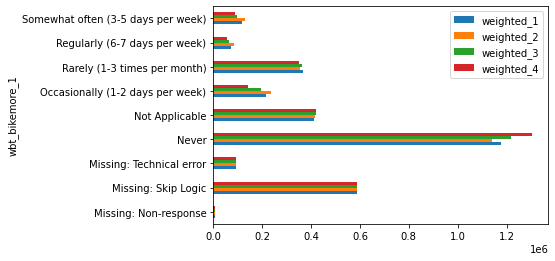

In [ ]:
df_tot.plot(kind='barh')

In [ ]:
# Group responses based on any positive answer (1 or more days per week)
df_grouped = pd.DataFrame(df_tot[df_tot.index.isin(['Occasionally (1-2 days per week)',
                            # 'Rarely (1-3 times per month)',
                            'Regularly (6-7 days per week)',
                            'Somewhat often (3-5 days per week)'])].sum(axis=0), columns=['Weighted'])

In [ ]:
# Group responses based on any positive answer (1 or more days per week)
df_grouped_samples = pd.DataFrame(df_samples[df_samples.index.isin(['Occasionally (1-2 days per week)',
                            # 'Rarely (1-3 times per month)',
                            'Regularly (6-7 days per week)',
                            'Somewhat often (3-5 days per week)'])].sum(axis=0), columns=['Samples'])

In [ ]:
df_samples

,samples_1,samples_2,samples_3,samples_4
wbt_bikemore_1,,,,
Missing: Non-response,27,27,27,27
Missing: Skip Logic,1062,1062,1062,1062
Missing: Technical error,769,769,769,769
Never,3133,3082,3351,3625
Not Applicable,1307,1312,1329,1331
Occasionally (1-2 days per week),895,907,812,689
Rarely (1-3 times per month),1153,1158,1191,1260
Regularly (6-7 days per week),293,339,255,171
Somewhat often (3-5 days per week),638,621,481,343


In [ ]:
df_grouped_samples.to_clipboard()

In [ ]:
df_grouped['share'] = df_grouped['Weighted']/non_biker_pop[config["weight_col"]].sum()
df_grouped

,Weighted,share
weighted_1,404116.231025,0.112224
weighted_2,451491.620688,0.125380
weighted_3,357704.123510,0.099335
weighted_4,285137.038681,0.079183


In [ ]:
df_grouped.to_clipboard()


In [ ]:
# percent of population who are commuters
# Commuters defined as all workers except frequent telecommuters; 
# ([number of workers in region]-[workers who telecommute 5+ times per week])/(total regional population)
total_workers = person_df.loc[person_df['worker'] == '1+ job(s) (including part-time)', config["weight_col"]].sum()
telecommuters = person_df.loc[person_df['telecommute_freq'] == '5+ days', config["weight_col"]].sum()
total_pop = person_df[config["weight_col"]].sum()

(total_workers-telecommuters)/total_pop

0.518756701952508

# Trip

In [ ]:
# Load version with skims data
df = pd.read_csv(r'R:\e2projects_two\2018_base_year\survey\daysim_format\revised\skims_attached\_trip.tsv', sep='\t')
df_trip_id_mapping = pd.read_csv(r'R:\e2projects_two\2018_base_year\survey\daysim_format\revised\trip_id_tsvid_mapping.csv')
df = df.merge(df_trip_id_mapping,on='tsvid')

In [ ]:
df = df.merge(trip_df, on='trip_id')

In [ ]:
df['trexpfac'].sum()

13419247.930582311

In [ ]:

df['wt_dist'] = df['travdist']*df['trexpfac']

In [ ]:
transit_df = df[df['mode_simple'] == 'Transit']

In [ ]:
# Average transit trip length
transit_df = df[df['mode_simple'] == 'Transit']
(transit_df['wt_dist'].sum())/(transit_df['trexpfac'].sum())

7.552934213735855

In [117]:
# Average transit trip length *bus only
bus_df = df[df['mode_1'] == 'Bus (public transit)']
bus_df['wt_dist'].sum()/bus_df['trexpfac'].sum()

7.473201270582835

In [119]:
# Average auto occupancy
# (total auto trips as driver or passenger)/(total auto trips as driver only)
(df[df['mode_simple'] == 'Drive']['trexpfac'].sum())/df[(df['mode_simple'] == 'Drive') & 
                                                                    (df['driver'] == 'Driver')]['trexpfac'].sum()


1.3229955758823049

In [120]:
# Average bicycle commute mode share
commute_df = df[df['dest_purpose'].isin(['Went to primary workplace'])]
commute_df[commute_df['mode_simple'] == 'Bike']['trexpfac'].sum()/commute_df['trexpfac'].sum()

0.011218510847066415

In [123]:

# Average pedestrian commute mode share
commute_df.loc[commute_df['mode_simple'] == 'Walk','trexpfac'].sum()/commute_df['trexpfac'].sum()

0.10463339899766018

In [54]:
# Average bicycle mode share for non-commute trips
non_commute_df = trip_df[~trip_df['dest_purpose'].isin(['Went to primary workplace'])]
non_commute_df[non_commute_df['mode_simple'] == 'Bike'][config['trip_weight_col_17_19']].sum()/non_commute_df[config['trip_weight_col_17_19']trip_weight_col_17_19']].sum()

0.0068234403104436726

In [55]:
# Average pedestrian mode share for non-commute trips
non_commute_df[non_commute_df['mode_simple'] == 'Walk'][config['trip_weight_col_17_19']].sum()/non_commute_df[config['trip_weight_col_17_19']].sum()

0.10694394763371366

In [33]:
# Percent of travelers who are potential bicyclists


In [34]:
# Percent of travelers who are potential pdestrians


In [124]:
# Average bicycle trip length
bike_df = df[df['mode_simple'] == 'Bike']
bike_df['wt_dist'].sum()/bike_df['trexpfac'].sum()

2.9673769265799117

95th percentile distance:  1.67
avg walk distance:  0.5904344887298393


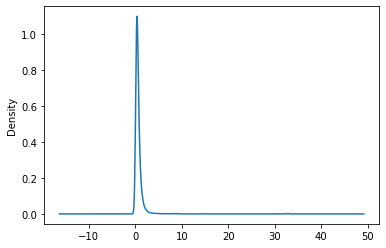

In [130]:
# Average pedestrian trip length
walk_df = df[df['mode_simple'] == 'Walk']

# Exclude trips to exercise and trips that have the same origin and destination parcel
walk_df = walk_df[walk_df['dest_purpose_cat'] != 'Social/Recreation']

# Exclude trips to and from same parcel
walk_df = walk_df[walk_df['origin_parcel_dim_id'] != walk_df['dest_parcel_dim_id']]

walk_df['travdist'].plot.kde()

# Exclude long tail of trips; find the 95th percentile distance (95% of trips shorter than this distance)
percentile_95 = walk_df['travdist'].describe(percentiles=[0.95])['95%']
print("95th percentile distance: ", percentile_95)
walk_df = walk_df[walk_df['travdist'] < percentile_95]

avg_dist = walk_df['wt_dist'].sum()/walk_df['trexpfac'].sum()
print("avg walk distance: ", avg_dist)

In [58]:
trip_df['origin_purpose_cat'].unique()

array(['Home', 'Errand/Other', 'Shop', 'Social/Recreation',
       'Work-related', 'School', 'Escort', 'Work', 'Meal', 'Change mode',
       'Missing: Non-response'], dtype=object)

In [131]:
# Average number of non-commute trips per day

noncommute_df = df[~((df['origin_purpose_cat'] == 'Home') & (trip_df['dest_purpose_cat'] == 'Work'))]
noncommute_df = noncommute_df[~((noncommute_df['dest_purpose_cat'] == 'Home') & 
                                (noncommute_df['origin_purpose_cat'] == 'Work'))]

noncommute_df['trexpfac'].sum()/total_pop

c:\Users\Modeller\.conda\envs\summary\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


3.0368227946901327

In [86]:
person_df.columnsx

Index(['worker', 'telecommute_freq', 'mode_freq_2', 'hh_weight_2021',
       'wbt_bikemore_1', 'wbt_bikemore_2', 'wbt_bikemore_3', 'wbt_bikemore_4'],
      dtype='object')

In [62]:
# Calculate regional mode shares

# Calculate hov2 and hov3 modes

# car_trip_df = trip_df.loc[trip_df['mode_simple'] == 'Drive']
trip_df['new_mode'] = trip_df['mode_simple']
trip_df.loc[(trip_df['travelers_total'] == 1) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'SOV'
trip_df.loc[(trip_df['travelers_total'] == 2) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'HOV2' 
trip_df.loc[(trip_df['travelers_total'] > 2) & (trip_df['mode_simple'] == 'Drive'), 'new_mode'] = 'HOV3+'

trip_df.groupby('new_mode').sum()[config['trip_weight_col_17_19']]/trip_df[config['trip_weight_col_17_19']].sum()

new_mode
Bike       0.007312
Drive      0.001521
HOV2       0.225765
HOV3+      0.175167
Other      0.008228
SOV        0.413491
Transit    0.060473
Walk       0.106598
Name: trip_weight_2017_2019, dtype: float64

In [63]:
# Average commute trip length
commute_df['trip_path_distance'].mean()

7.781115727411063

10.291568832717191

In [ ]:
# HOV eligible mode share along corridor (2)

In [ ]:
# HOV eligible mode share along corridor (3_)

In [454]:
# Average commute trip length
commute_df = trip_df[((trip_df['origin_purpose_cat'] == 'Home') & (trip_df['dest_purpose_cat'] == 'Work'))]
commute_df['wt_dist'].sum()/commute_df[config['trip_weight_col_17_19']].sum()

10.93586442037644

In [ ]:
# Percent of potential pedestrians who would walk if there was a sidewalk serving their destination

# Dropped in 2017
# Can consider adding for 2025 with note to not include for other years? 

# Soundcast Trip Data